## Introduction

A majority of wind farm layout processes are conducted on a manual basis. The overwhelming amount of information to handle when searching for the best wind turbines layout paved the way for computer aided optimization. By studying the optimal layout of the wind farm, we can ensure that the space is being used the most effectively to generate a less carbon intensive form of energy.

For this optimization problem, we utilize the Wind Turbine Database of Canada. We will focus specifically on the Gosfield wind project in Kingsville, Ontario. Construction of the wind farm was completed in 2010. We will create a network layout optimization problem based on a grid-layer map to determine the most optimal location to erect windmills subject to budget constraints. The result will then be compared with the actual location of the windmills to provide any future improvements.

In [16]:
#import libraries
import gurobipy as gp
from gurobipy import *
import numpy as np
import pandas as pd
#from shapely.geometry import Point, Polygon
#import geopandas as gpd
import matplotlib.pyplot as plt
import random
import datetime
#import contextily as cx
#import networkx as nx

## Pre-process: Plot the Actual Wind Farm Using the Collected Data 

In [30]:
## Load Dataset
df = pd.read_excel("Wind_Turbine_Database_FGP.xlsx")
df2 = df.drop(['OBJECTID','Turbine identifier','Model','Commissioning date','Notes','Manufacturer'],axis = 1)

In [31]:
df2

,Province/Territory,Project name,Total project capacity (MW),Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Latitude,Longitude
0,Alberta,Optimist Wind Energy,0.90,1/2,150,23.0,30.0,49.525354,-114.054796
1,Alberta,Castle River Wind Farm,44.00,1/60,600,44.0,40.0,49.512641,-114.035712
2,Alberta,Waterton Wind Turbines,3.78,1/6,600,44.0,50.0,49.233069,-113.654899
3,Alberta,Waterton Wind Turbines,3.78,2/6,600,44.0,50.0,49.233034,-113.630213
4,Alberta,Waterton Wind Turbines,3.78,3/6,600,44.0,50.0,49.217547,-113.680161
...,...,...,...,...,...,...,...,...,...
6693,Saskatchewan,Cypress,10.56,14/16,660,47.0,50.0,50.019248,-108.533930
6694,Saskatchewan,Cypress,10.56,15/16,660,47.0,50.0,50.015566,-108.532063
6695,Saskatchewan,Cypress,10.56,16/16,660,47.0,50.0,50.010855,-108.538380
6696,Yukon,Haeckel Hill,0.81,1/2,150,23.0,30.0,60.748818,-135.229274


In [32]:
## Restricting area to our selcted project
df_gos = df2.loc[df['Project name'] == 'Pubnico Point']
df_gos.head(5)

,Province/Territory,Project name,Total project capacity (MW),Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Latitude,Longitude
1768,Nova Scotia,Pubnico Point,30.6,1/17,1800,80.0,78.0,43.606459,-65.795618
1769,Nova Scotia,Pubnico Point,30.6,2/17,1800,80.0,78.0,43.606102,-65.799889
1770,Nova Scotia,Pubnico Point,30.6,3/17,1800,80.0,78.0,43.606061,-65.804429
1771,Nova Scotia,Pubnico Point,30.6,4/17,1800,80.0,78.0,43.605934,-65.809029
1772,Nova Scotia,Pubnico Point,30.6,5/17,1800,80.0,78.0,43.605631,-65.813370


In [33]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(df_gos['Longitude'], df_gos['Latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}


# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df_gos, crs=crs, geometry=geometry)


/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [34]:
gdf.head(2)

,Province/Territory,Project name,Total project capacity (MW),Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Latitude,Longitude,geometry
1768,Nova Scotia,Pubnico Point,30.6,1/17,1800,80.0,78.0,43.606459,-65.795618,POINT (-65.79562 43.60646)
1769,Nova Scotia,Pubnico Point,30.6,2/17,1800,80.0,78.0,43.606102,-65.799889,POINT (-65.79989 43.60610)


In [35]:
gdf2 = gdf.to_crs(epsg=3857)
gdf2.head(2)

,Province/Territory,Project name,Total project capacity (MW),Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Latitude,Longitude,geometry
1768,Nova Scotia,Pubnico Point,30.6,1/17,1800,80.0,78.0,43.606459,-65.795618,POINT (-7324334.742 5404741.477)
1769,Nova Scotia,Pubnico Point,30.6,2/17,1800,80.0,78.0,43.606102,-65.799889,POINT (-7324810.130 5404686.595)


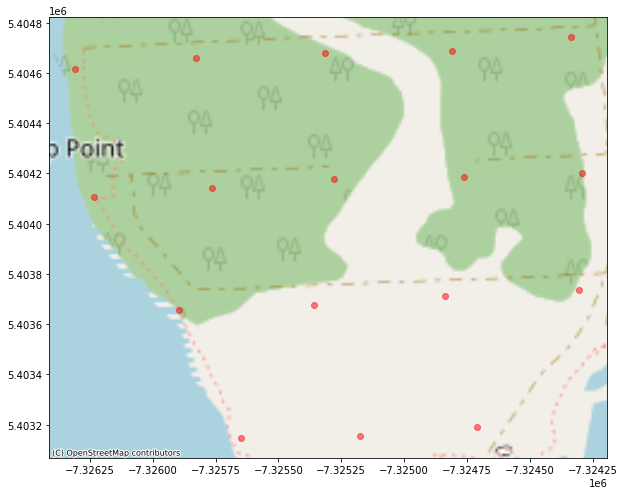

In [36]:
# Plot all points

ax = gdf2.plot(figsize=(10, 10), alpha=0.5, edgecolor='red', color='red')
cx.add_basemap(ax, zoom = 14, source=cx.providers.OpenStreetMap.Mapnik)

## Model 1 - Base Model (without considering the Wake Effect)

In [15]:
import networkx as nx
import gurobipy as gp
from gurobipy import *

#A 6x6 grid
L = 6

prob = gp.Model("Wind farm layout optimization")


X = prob.addVars(e,e , vtype = GRB.BINARY , name = ["wind turbine at["+str(i)+", " +str(j) + "]" for i in range(L) for j in range(L)])


# Objective: Maximize wind output
P = 1800

prob.setObjective(sum(X[i,j] for i in range(L) for j in range(L))*P, GRB.MAXIMIZE)


# For internal grid

for i in range(1,L-1):
    for j in range(1,L-1):
        prob.addConstr(X[i,j]*(X[i+1,j]+X[i-1,j]+X[i,j+1]+X[i,j-1]) == 0)
    
# For corner points
# top left
prob.addConstr(X[0,0]*(X[0,1]+X[1,0]) == 0)

#bottom right

prob.addConstr(X[L-1,L-1]*(X[L-1,L-2]+X[L-2,L-1]) == 0)

# top right

prob.addConstr(X[0,L-1]*(X[0,L-2]+X[1,L-1]) == 0)

# bottom left
prob.addConstr(X[L-1,0]*(X[L-1,1]+X[L-2,0]) == 0)


# For top edge
for j in range (1,L-2):
    prob.addConstr(X[0,j]*(X[0,j-1]+X[0,j+1]+X[1,j])==0)

# for bottom edge
for j in range (1,L-2):
    prob.addConstr(X[L-1,j]*(X[L-1,j-1]+X[L-1,j+1]+X[L-2,j])==0)

# for right edge
for i in range (1,L-2):
    prob.addConstr(X[i,L-1]*(X[i-1,L-1]+X[i+1,L-1]+X[i,L-2])==0 )


# for left edge
for i in range (1,L-2):
    prob.addConstr(X[i,0]*(X[i+1,0]+X[i-1,0]+X[i,1])==0 )

    
### optional: forcing some nodes to be 1, some to be 0 based on condition constraints
prob.addConstr(X[2,0] == 0)
prob.addConstr(X[3,0] == 0)
prob.addConstr(X[4,0] == 0)
prob.addConstr(X[5,0] == 0)
prob.addConstr(X[4,1] == 0)
prob.addConstr(X[5,1] == 0)
prob.addConstr(X[4,5] == 0)
prob.addConstr(X[5,4] == 0)
prob.addConstr(X[5,5] == 0)


prob.update()

prob.Params.LogToConsole = 1
prob.optimize()

print("obj val", prob.objVal)
for v in prob.getVars():
    if v.x > 0:
        print(v.varName, "=", v.x)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9 rows, 36 columns and 9 nonzeros
Model fingerprint: 0x483ee030
Model has 32 quadratic constraints
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+03, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve added 33 rows and 0 columns
Presolve removed 0 rows and 9 columns
Presolve time: 0.00s
Presolved: 42 rows, 27 columns, 84 nonzeros
Variable types: 0 continuous, 27 integer (27 binary)
Found heuristic solution: objective 25200.000000

Root relaxation: cutoff, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

In [16]:
#Map the layout in data frame matrix

all_vars=prob.getVars()
lst=[]
lb=0
ub=e
for i in range(e):
    temp=[]
    for j in range(lb,ub):
        temp.append(int(all_vars[j].X))
    lst.append(temp)
    lb+=e
    ub+=e

column_name=[0,1,2,3,4,5]
df=pd.DataFrame(data=lst,columns=column_name,index=column_name)

def highlighter(cell_value):
    if cell_value ==1 :
        return "background-color: yellow"

df.style.applymap(highlighter)

,0,1,2,3,4,5
0,1,0,1,0,1,0
1,0,1,0,1,0,1
2,0,0,1,0,1,0
3,0,1,0,1,0,1
4,0,0,1,0,1,0
5,0,0,0,1,0,0



## Model 2 - Taking into account of the wake effect

Taking into consideration energy production from the wind, wind turbines are used. They are often defined by the wake effect where cones (wakes) of slower and more turbulent air are created behind them. To mitigate this phenomenon, it is recommended that wind turbines be installed with minimum distance between them.
<br> Model 2 also take into consideration the amount of energy loss due to the wake effect if turbines are placed in the vicinity of one another. 


In [7]:
import networkx as nx
import gurobipy as gp
from gurobipy import *


L = 8 #+2 to incorporate the wake effect. The layout is still 6x6


prob = gp.Model("Wind farm layout optimization")

X = prob.addVars(L,L , vtype = GRB.BINARY , name = ["wind turbine at["+str(i)+", " +str(j) + "]" for i in range(L) for j in range(L)])


# Setting Objective Function
P = 1800

prob.setObjective(sum(X[i,j] - 0.33*P*X[i+1,j+1]*X[i,j] - 0.33*P*X[i,j+2]*X[i,j]-0.33*P*X[i-1,j+1]*X[i,j] for i in range(1,7) for j in range(0,6))*P, GRB.MAXIMIZE)


# For internal grid

for i in range(1,L-1):
    for j in range(1,L-1):
        prob.addConstr(X[i,j]*(X[i+1,j]+X[i-1,j]+X[i,j+1]+X[i,j-1]) == 0)
    
# For corner points - might not need it 

# top left
prob.addConstr(X[0,0]*(X[0,1]+X[1,0]) == 0)

#bottom right

prob.addConstr(X[L-1,L-1]*(X[L-1,L-2]+X[L-2,L-1]) == 0)

# top right

prob.addConstr(X[0,L-1]*(X[0,L-2]+X[1,L-1]) == 0)

# bottom left
prob.addConstr(X[L-1,0]*(X[L-1,1]+X[L-2,0]) == 0)


# For top edge
for j in range (1,L-2):
    prob.addConstr(X[0,j]*(X[0,j-1]+X[0,j+1]+X[1,j])==0)

# for bottom edge
for j in range (1,L-2):
    prob.addConstr(X[L-1,j]*(X[L-1,j-1]+X[L-1,j+1]+X[L-2,j])==0)

# for right edge
for i in range (1,L-2):
    prob.addConstr(X[i,L-1]*(X[i-1,L-1]+X[i+1,L-1]+X[i,L-2])==0 )


# for left edge
for i in range (1,L-2):
    prob.addConstr(X[i,0]*(X[i+1,0]+X[i-1,0]+X[i,1])==0 )

    
### NEW: forcing some nodes to be 1, some to be 0
prob.addConstr(X[3,0] == 0)
prob.addConstr(X[4,0] == 0)
prob.addConstr(X[5,0] == 0)
prob.addConstr(X[6,0] == 0)
prob.addConstr(X[5,1] == 0)
prob.addConstr(X[6,1] == 0)
prob.addConstr(X[5,5] == 0)
prob.addConstr(X[6,4] == 0)
prob.addConstr(X[6,5] == 0)



prob.update()

prob.Params.LogToConsole = 1
prob.optimize()

print("obj val", prob.objVal)
for v in prob.getVars():
    if v.x > 0:
        print(v.varName, "=", v.x)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9 rows, 64 columns and 9 nonzeros
Model fingerprint: 0xf0709a46
Model has 108 quadratic objective terms
Model has 60 quadratic constraints
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+03, 2e+03]
  QObjective range [2e+06, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve added 33 rows and 0 columns
Presolve removed 0 rows and 37 columns
Presolve time: 0.00s
Presolved: 93 rows, 78 columns, 237 nonzeros
Variable types: 0 continuous, 78 integer (78 binary)
Found heuristic solution: objective 12600.000000

Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 second

In [8]:
#Map the layout in data frame matrix.
import pandas as pd

all_vars=prob.getVars()
lst=[]
lb=0
ub=L
for i in range(L):
    temp=[]
    for j in range(lb,ub):
        temp.append(int(all_vars[j].X))
    lst.append(temp)
    lb+=L
    ub+=L

column_name=[0,1,2,3,4,5,6,7]
df=pd.DataFrame(data=lst,columns=column_name,index=column_name)

def highlighter(cell_value):
    if cell_value ==1 :
        return "background-color: yellow"

df.style.applymap(highlighter)


,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0


In [43]:
print("**Additional Note: \nThe top and the bottom row, as well as the 2 rows on the right are the assistant edges to account for the wake effect. The real layout are from row 1-6, and column 0-5.")

**Additional Note: 
The top and the bottom row, as well as the 2 rows on the right are the assistant edges to account for the wake effect. The real layout are from row 1-6, and column 0-5.


## Problem Extension 1: Modelling Turbine Layout As a Graph

An alternative way that allows us to solve this optimization problem and affords more flexibility and scability is to imagine the turbine locations as a graph and solve the problem as a 'Maximun stable set' optimization problem. 

We've imagined the square optimization grid as an undirected graph 𝐺=(𝑉,𝐸) using the networkx library in python that allows you to work with graphs. We've then identified the neighbours of each node and added contraints on the neigbours to get the optimal layout. 

Similar to the previous problem, we can force some nodes to be on or off and doing that reshuffles the resultant grid. 





In [10]:
import networkx as nx
import numpy as np
import gurobipy as gp
from gurobipy import *

# Creating an undirected graph G with all the possible wind turbine locations
L = 8
G = nx.grid_graph(dim=(L,L))
P = 15


# defining the model and variables
gprob = gp.Model("Wind Farm Layout - Using Graphs")

#pos = len(G.nodes)

# Decision Variables - whether the turbine site is selected or not

X = gprob.addVars(L,L, vtype = GRB.BINARY, name = [ "Node " +str(i) for i in G.nodes])

# Objective function - maximize production

gprob.setObjective(sum(X[i,j]*P - 0.33*P*X[i+1,j+1]*X[i,j] - 0.33*P*X[i,j+2]*X[i,j]-0.33*P*X[i-1,j+1]*X[i,j]for i in range(1,5) for j in range(0,5)), GRB.MAXIMIZE)

# Constraints - Only one among all neighbors selected
for v in G.nodes:
    gprob.addConstr(sum(X[n] for n in G.neighbors(v))*X[v] == 0)
    
## OPTIONALLY - WE CAN ENFORCE CONSTRAINTS TO PLACE TURBNIES AT CERTAIN LOCATIONS 
## OR NOT PLACE TURBINES AT CERTAIN LOCATIONS AS MODELLED ABOVE 

#gprob.addConstr(X[0,1] == 1)
#gprob.addConstr(X[3,1] == 0)


gprob.optimize()


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 64 columns and 0 nonzeros
Model fingerprint: 0x4e97834c
Model has 60 quadratic objective terms
Model has 64 quadratic constraints
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve added 31 rows and 0 columns
Presolve removed 0 rows and 44 columns
Presolve time: 0.00s
Presolved: 67 rows, 56 columns, 170 nonzeros
Variable types: 0 continuous, 56 integer (56 binary)
Found heuristic solution: objective 90.3000000

Root relaxation: objective 1.500000e+02, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     

In [11]:
print("obj val", gprob.objVal)
for v in gprob.getVars():
    if v.x > 0:
        print(v.varName, "=", v.x)

obj val 90.29999999999998
Node (1, 0) = 1.0
Node (1, 3) = 1.0
Node (2, 1) = 1.0
Node (2, 4) = 1.0
Node (3, 0) = 1.0
Node (3, 3) = 1.0
Node (4, 1) = 1.0
Node (4, 4) = 1.0


In [14]:
#Map the layout in data frame matrix

all_vars=gprob.getVars()
lst=[]
lb=0
ub=L
for i in range(L):
    temp=[]
    for j in range(lb,ub):
        temp.append(int(all_vars[j].X))
    lst.append(temp)
    lb+=L
    ub+=L


column_name=nx.grid_graph(dim=(L,L))
column_name=[0,1,2,3,4,5,6,7]
df=pd.DataFrame(data=lst,columns=column_name,index=column_name)

def highlighter(cell_value):
    if cell_value ==1 :
        return "background-color: yellow"

df.style.applymap(highlighter)

,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0
3,1,0,0,1,0,0,0,0
4,0,1,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0


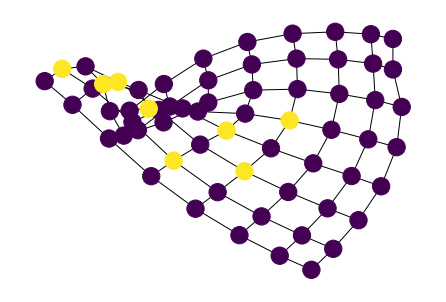

In [17]:
# Visualizing the map of the optimal result

val_map = {}
for i in range(L):
    for j in range(L):
        index  = "(" + str(i) + ", " + str(j) + ")"
        val_map[index] = X[i,j].x
        
values = [val_map.get(str(node)) for node in G.nodes()]
nx.draw(G, node_color=values, font_color='white')
plt.show()

## Problem Extension 2: Irregular graph with variable distances

In the modelling examples so far, we've used a uniformly spaced regular grid as the location of the windfarm. But realistically, especially for onshore windfarm projects, having a regular grid may not be the case. Due to wind resource availability, topological constraints and other considerations it is possible to have a wind farm where all the candidate nodes are variable disatance apart from each other. In the problem below, we've tried to model this problem by looking at the pairwise distance between each of the nodes to maximize the production output

In [27]:
#solution
import networkx as nx
import gurobipy as gp
from gurobipy import *


# create the graph

G = nx.Graph()

nodes = ['a','b','c','d','e']
edges = [('a','b',6),('b','c',4),('a','c',4),('c','d',4),('c','e',3),('d','e',4),('a','d',8),('b','e',9)]

G.add_nodes_from(nodes)

for start, end, length in edges:
    G.add_edge(start, end, length=length)                              

# defining the model and variables
gprob = gp.Model("Wind Farm Layout - Using Asymmetric Graphs")

L = len(nodes)
P = 15

X = {}
for i in nodes:
    X[i] = gprob.addVar(name = i, vtype = GRB.BINARY)

gprob.setObjective(sum(X[i] for i in nodes)*P, GRB.MAXIMIZE)

# if distance between two nodes is more than minimin distance then both can be picked, else only one can be picked
dist = nx.get_edge_attributes(G, "length")

for u, v, weight in G.edges.data("length"):
    gprob.addConstr(X[u] +X[v] -1 <= (weight/5)) # 5 is the min required distance

gprob.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8 rows, 5 columns and 16 nonzeros
Model fingerprint: 0xe15a8892
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+00]
Found heuristic solution: objective 45.0000000
Presolve removed 8 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 45 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.500000000000e+01, best bound 4.500000000000e+01, gap 0.0000%


In [28]:
print("obj val", gprob.objVal)
for v in gprob.getVars():
    if v.x > 0:
        print(v.varName, "=", v.x)

obj val 45.0
a = 1.0
b = 1.0
d = 1.0


## Problem Extension 3: Irregular graph with actual distances using Lat and Long

This is an extension of probelm extension 2 but with actual latitude and longitudes to visualize the optimized layout on a graph

In [26]:
## Load Dataset

locs = pd.read_excel("/Users/zhenyewu/Desktop/Decision Analysis/Project/Turbine Edge List.xlsx",sheet_name='Sheet2')

In [27]:
locs

,Source,Source Long,Source Lat
0,a,43.606369,-65.809375
1,b,43.606013,-65.806334
2,c,43.606432,-65.803786
3,d,43.606621,-65.800659
4,e,43.604231,-65.808419
5,f,43.603182,-65.808361
6,g,43.603392,-65.805871
7,h,43.603623,-65.802309
8,i,43.603811,-65.796981
9,j,43.599659,-65.804191


/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


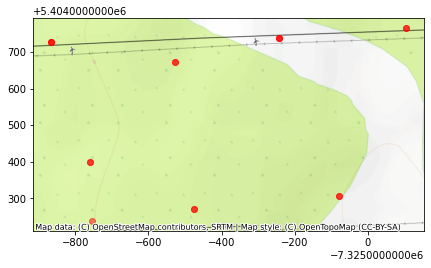

In [41]:
## Plotting all potential nodes on a map

# creating a geometry column 
geometry = [Point(xy) for xy in zip(locs['Source Lat'], locs['Source Long'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}


# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(locs, crs=crs, geometry=geometry)

gdf2 = gdf.to_crs(epsg=3857)
gdf2

# Plot all points

ax = gdf2.plot(figsize=(7, 7), alpha=0.5, edgecolor='red', color='red')
cx.add_basemap(ax, zoom = 17, source=cx.providers.OpenTopoMap)



In [30]:
## Reading Edges of the Irregular Graph

locs = pd.read_excel("/Users/zhenyewu/Desktop/Decision Analysis/Project//Turbine Edge List.xlsx",sheet_name='Sheet1')


In [31]:
# Calculating distances using lat and long for each edge
from math import radians, cos, sin, asin, sqrt
def distance(x):

    lon1 = radians(x['Source Long'])
    lon2 = radians(x['Target Long'])
    lat1 = radians(x['Source Lat'])
    lat2 = radians(x['Target Lat'])
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    r = 6371
      
    # calculate the result in meters
    return(c * r*1000)


## calculate distance for each edge
locs['length']  = locs.apply(distance, axis=1)

In [32]:
locs

,source,target,Source Long,Source Lat,Target Long,Target Lat,length
0,a,b,43.606369,-65.809375,43.606013,-65.806334,338.532664
1,b,c,43.606013,-65.806334,43.606432,-65.803786,283.967398
2,c,d,43.606432,-65.803786,43.606621,-65.800659,347.813223
3,a,c,43.606369,-65.809375,43.606432,-65.803786,621.475076
4,a,e,43.606369,-65.809375,43.604231,-65.808419,144.189824
5,b,e,43.606013,-65.806334,43.604231,-65.808419,245.650822
6,d,i,43.606621,-65.800659,43.603811,-65.796981,428.564372
7,d,h,43.606621,-65.800659,43.603623,-65.802309,228.765617
8,e,f,43.604231,-65.808419,43.603182,-65.808361,48.232392
9,e,g,43.604231,-65.808419,43.603392,-65.805871,285.892581


In [33]:
## creating graph using the edges and distances
edges = locs[['source','target','length']]
G = nx.from_pandas_edgelist(edges, edge_attr=True)


In [34]:
## creating an array of names for all nodes
nodes = ['a','b','c','d','e','f','g','h','i','j']

# defining the model and variables
agprob = gp.Model("Wind Farm Layout - Using Asymmetric Graphs")

L = len(nodes)
P = 15

X = {}
for i in nodes:
    X[i] = agprob.addVar(name = i, vtype = GRB.BINARY)

agprob.setObjective(sum(X[i] for i in nodes)*P, GRB.MAXIMIZE)


# if distance between two nodes is more than minimin distance then both can be picked, else only one

#dist = nx.get_edge_attributes(G, "length")

for u, v, weight in G.edges.data("length"):
    agprob.addConstr(X[u] +X[v] -1 <= (weight/250)) # 250 is the minimun distance 
 

In [35]:
agprob.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17 rows, 10 columns and 34 nonzeros
Model fingerprint: 0x072abc14
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 120.0000000
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 120 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+02, best bound 1.200000000000e+02, gap 0.0000%


In [45]:
print("obj val", agprob.objVal)
for v in agprob.getVars():
    print(v.varName, "=", v.x)

obj val 120.0
a = 1.0
b = 1.0
c = 1.0
d = 1.0
e = 0.0
f = 1.0
g = 1.0
h = 0.0
i = 1.0
j = 1.0


# Using data from Pubnico Point

Modelling the wind farm layout using data from pubnico wind farm in Nova Scotia

In [54]:
## Load Dataset

locs = pd.read_excel("/Users/zhenyewu/Desktop/Decision Analysis/Project/Turbine Edge List.xlsx",sheet_name='Sheet4')

In [55]:
## calculate distance for each edge (each node is connected by edges to its neighbors)
locs['length']  = locs.apply(distance, axis=1)
locs

,source,target,Source Long,Source Lat,Target Long,Target Lat,length
0,PUB1,PUB2,43.606459,-65.795618,43.606102,-65.799889,475.135405
1,PUB1,PUB6,43.606459,-65.795618,43.602330,-65.812694,1907.987430
2,PUB1,PUB7,43.606459,-65.795618,43.602551,-65.808448,1437.707319
3,PUB2,PUB3,43.606102,-65.799889,43.606061,-65.804429,504.838381
4,PUB2,PUB6,43.606102,-65.799889,43.602330,-65.812694,1434.167118
5,PUB2,PUB7,43.606102,-65.799889,43.602551,-65.808448,965.435044
6,PUB2,PUB8,43.606102,-65.799889,43.602779,-65.804094,491.453165
7,PUB3,PUB4,43.606061,-65.804429,43.605934,-65.809029,511.537475
8,PUB3,PUB7,43.606061,-65.804429,43.602551,-65.808448,474.701003
9,PUB3,PUB8,43.606061,-65.804429,43.602779,-65.804094,154.164372


In [71]:
## creating graph using the edges and distances
edges = locs[['source','target','length']]
G = nx.from_pandas_edgelist(edges, edge_attr=True)

## creating an array of names for all nodes
nodes = ['PUB1','PUB2','PUB3','PUB4','PUB5','PUB6','PUB7','PUB8','PUB9','PUB10','PUB11','PUB12','PUB13','PUB14','PUB15','PUB16','PUB17']

# defining the model and variables
agprob = gp.Model("Wind Farm Layout - Using Asymmetric Graphs")

L = len(nodes)
P = 15

X = {}
for i in nodes:
    X[i] = agprob.addVar(name = i, vtype = GRB.BINARY)

agprob.setObjective(sum(X[i] for i in nodes)*P, GRB.MAXIMIZE)


# if distance between two nodes is more than minimin distance then both can be picked, else only one

#dist = nx.get_edge_attributes(G, "length")
r=80 #radio diameter is 80m

for u, v, weight in G.edges.data("length"):
    agprob.addConstr(X[u] +X[v] -1 <= (weight/(r*5))) # 5 r apart is the minimun distance based on the research data
 


agprob.optimize()

print("obj val", agprob.objVal)
for v in agprob.getVars():
    if v.x == 1:
        print(v.varName, "=", v.x)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 42 rows, 17 columns and 84 nonzeros
Model fingerprint: 0x3d11dc94
Variable types: 0 continuous, 17 integer (17 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 210.0000000
Presolve removed 42 rows and 17 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 210 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.100000000000e+02, best bound 2.100000000000e+02, gap 0.0000%
obj val 210.0
PUB1 = 1.0
PUB2 = 1.0
PUB3 = 1.0
PUB4 = 1.0
PUB5 = 1.0
PUB6 = 1.0
PUB7 = 1.0
PUB9 = 1.0
PUB10 = 1.0
PUB11 = 1.0
PUB13 = 1.0
PUB

/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


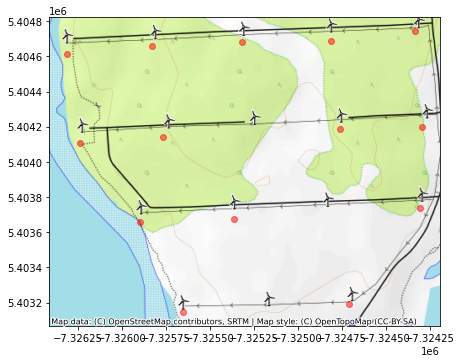

In [72]:
locs_result = pd.read_excel("/Users/zhenyewu/Desktop/Decision Analysis/Project/Turbine Edge List.xlsx",sheet_name='Sheet5')
## Plotting all potential nodes on a map
 
# creating a geometry column 
geometry = [Point(xy) for xy in zip(locs_result['Source Lat'], locs_result['Source Long'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}


# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(locs_result, crs=crs, geometry=geometry)

gdf2 = gdf.to_crs(epsg=3857)
gdf2


# Plot all points

ax = gdf2.plot(figsize=(7, 7), alpha=0.5, edgecolor='red', color='red')
cx.add_basemap(ax, zoom = 15, source=cx.providers.OpenTopoMap)

